### Background knowledge:
The dataset contains multiple activities() in time sequence </br>
Type of activity:
- 1=walking; 
- 2=descending stairs; 
- 3=ascending stairs; 
- 4=driving;
- 77=clapping; 
- 99=non-study activity
</br>
The **goal** of the project is to use Nerual networks (deep learning) methods to distinguish which activity is which.</br>
More info refer to file [raw_accelerometry_data_dict.csv](A1/data/raw/physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data_dict.csv
)

The workflow of preprocessing:
- 1:load the dataset
- 2:seperate the activity and plot each divices on different body part
- 3:standardize and normalize data
- 4:use sliding window and segementation
- 5:calculate Vector magnitude func:calculate_vector_magnitude
- 6:use noise reduction
- 7:use FFT 
 

### TODO:
- make train / test dataset
- make CNN / LSTM etc models
- build training pipeline
- evaluation and compare 
- find the results


https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb


In [1]:
import os 
import matplotlib
import calendar

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.signal import medfilt, butter, filtfilt

#### Fetch the dataset

In [2]:
!wget -c --timeout 10 https://physionet.org/static/published-projects/accelerometry-walk-climb-drive/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0.zip -O dataset.zip
!unzip -d dataset -q dataset.zip
!echo "Done!"

--2023-12-01 03:00:00--  https://physionet.org/static/published-projects/accelerometry-walk-climb-drive/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184676079 (176M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 176,12M  1,03MB/s    in 2m 57s  

2023-12-01 03:02:57 (1020 KB/s) - ‘dataset.zip’ saved [184676079/184676079]

Done!


In [3]:
!ls dataset/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data/

id00b70b13.csv id3e3e50c7.csv id82b9735c.csv idb221f542.csv idf540d82b.csv
id079c763c.csv id4ea159a8.csv id86237981.csv idbae5a811.csv idf5e3678b.csv
id1165e00c.csv id5308a7d6.csv id8af5374b.csv idc735fc09.csv idfc5f05e4.csv
id1c7e64ad.csv id5993bf4a.csv id8e66893c.csv idc91a49d0.csv idff99de96.csv
id1f372081.csv id650857ca.csv id9603e9c3.csv idd80ac2b4.csv
id34e056c8.csv id687ab496.csv ida61e8ddf.csv idecc9265e.csv
id37a54bbf.csv id7c20ee7a.csv idabd0c53c.csv idf1ce9a0f.csv


In [4]:
def read_single_file(file_path):
    df = pd.read_csv(file_path)
    return df   
    # select by activity and plot them



In [5]:
def read_all_data(folder_path):
    # List to store the DataFrames
    data_frames = []
    for filename in os.listdir(folder_path):
        
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path,filename)
            df = pd.read_csv(file_path)
            data_frames.append(df)
        else:
            print(f"{filename} is not a csv file")
        
    return data_frames 
    # print(df.head(5))




#### plotting

In [6]:
def plot_all(df,path):
    sns.set_theme(context='notebook', style='darkgrid', palette="deep")
    # variables = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z"]

    variables = {
    'magnitude_0': 'lw',
    'magnitude_1': 'lh',
    'magnitude_2': 'la',
    'magnitude_3': 'ra'
}
   
    # df.plot(x='time_s', y=variables)
    df.plot(x='time_s', y=list(variables.keys()))
    # tick_positions = range(0, 3034, 100) 
    # plt.xticks(tick_positions)
    # Adding labels and a legend
    
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend([variables[var] for var in variables.keys()])
    
    # Displaying the plot
    # plt.show()
    plt.savefig(path)

# plot(combined_df)



In [7]:
def make_x_y_z_plot(df):
    # colors = ["#F7F3E3","#7F7CAF","#78C0E0"]
    option_colors = sns.color_palette()
    colors =[option_colors[0],option_colors[1],option_colors[2]]
    # create larger subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        # Plotting
    for i, (ax, variables) in enumerate(zip(axs.flat, [('lw_x', 'lw_y', 'lw_z'), ('lh_x', 'lh_y', 'lh_z'), ('la_x', 'la_y', 'la_z'), ('ra_x', 'ra_y', 'ra_z')])):
        for variable, color in zip(variables, colors):
            sns.lineplot(data=df, x='time_s', y=variable, ax=ax, linewidth=0.5, color=color, label=variable)
        
        ax.legend(loc='upper right', fontsize=12)
        ax.set_title(' vs time_s '.join(variables), fontsize=16)
        ax.set_xlabel('Time (s)', fontsize=14)
        ax.set_ylabel('Value', fontsize=14)
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    

#### seperate activity for plotting


In [8]:
# separate each activity based on the numebr
def separate_activity(df,activity):
    if activity == 99:
        df_non_study = df[df['activity'] == 99]
        return df_non_study
    elif activity == 77:
        df_clapping = df[df['activity'] == 77]
        return df_clapping
    elif activity ==4:
        df_driving = df[df['activity'] == 4]
        return df_driving
    elif activity ==3:
        df_ascending_stairs = df[df['activity'] == 3]
        return df_ascending_stairs
    elif activity ==2:
        df_descending_stairs = df[df['activity'] == 2]
        return df_descending_stairs
    elif activity ==1:
        df_walking = df[df['activity'] == 1]
        return df_walking


In [9]:
# show the period of each activity
def show_x_y_z_plot(df,activity):
    if activity == 99:
        df_non_study = df[df['activity'] == 99]
        # df_99 = df_99[(df_99['time_s'] >= 2600) & (df_99['time_s'] <= 2800)]
        make_x_y_z_plot(df_99)
    elif activity == 77:
        df_77 = df[df['activity'] == 77]
        # df_77 = df_77[(df_77['time_s'] >= 520) & (df_77['time_s'] <= 540)]
        make_x_y_z_plot(df_77)
    elif activity ==4:
        df_4 = df[df['activity'] == 4]
        # df_4 = df_4[(df_4['time_s'] >= 1400) & (df_4['time_s'] <= 1600)]
        make_x_y_z_plot(df_4)
    elif activity ==3:
        df_3 = df[df['activity'] == 3]
        # df_3 = df_3[(df_3['time_s'] >= 300) & (df_3['time_s'] <= 350)]
        make_x_y_z_plot(df_3)
    elif activity ==2:
        df_2 = df[df['activity'] == 2]
        # df_2 = df_2[(df_2['time_s'] >= 300) & (df_2['time_s'] <= 350)]
        make_x_y_z_plot(df_2)
    elif activity ==1:
        df_1 = df[df['activity'] == 1]
        # df_1 = df_1[(df_1['time_s'] >= 650) & (df_1['time_s'] <= 750)] 
        make_x_y_z_plot(df_1)




In [10]:
from sklearn.preprocessing import StandardScaler

def standardize(df):
    # initialize standard scaler
    scaler = StandardScaler()
    # select the columns to standardize
    # columns_to_standardize = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z"]
    
    columns_to_standardize = ['magnitude_0','magnitude_1', 'magnitude_2', 'magnitude_3']

    # standardize the columns
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
    # Convert the 'time_s' column to a datetime format if it isn't already
    df['time_s'] = pd.to_datetime(df['time_s'], unit='s') 
    # Set the 'time_s' column as the index of the DataFrame
    df.set_index('time_s', inplace=True)
        # check if the data has been standardized
    # print(df[columns_to_standardize].mean())  # should be close to 0
    # print(df[columns_to_standardize].std())   # should be close to 1

    # Reset the index back to RangeIndex
    df.reset_index(inplace=True)
    # Convert 'time_s' back to its original unit
    df['time_s'] = df['time_s'].astype(int)

    return df




In [11]:
def butter_lowpass(cutoff, fs, order=3):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(df, columns, cutoff, fs, order=3):
    df_filtered = df.copy()
    for column in columns:
        b, a = butter_lowpass(cutoff, fs, order=order)
        df_filtered[column] = filtfilt(b, a, df[column].values)
    return df_filtered

In [12]:
def apply_noise_filter(df):
    # Assuming you want to apply a median filter and low-pass Butterworth filter
    # columns_to_apply_filter = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z"]
    columns_to_apply_filter = ['magnitude_0','magnitude_1', 'magnitude_2', 'magnitude_3']

    # Apply median filter to the specified columns
    df_filtered = df.copy()
    for column in columns_to_apply_filter:
        df_filtered[column] = medfilt(df[column], kernel_size=5)  # Adjust kernel size as needed

    # Apply low-pass Butterworth filter to the filtered data
    cutoff_freq = 0.2  # Corner frequency in Hz
    order = 3  # Butterworth filter order
    fs = 100  # Sample rate (assuming equally spaced samples)
    df_filtered = butter_lowpass_filter(df_filtered, columns_to_apply_filter, cutoff_freq, fs, order)

    return df_filtered

In [13]:
# standardize and segment
def data_processed(df):
    
    df_new = standardize(df)
    # Assuming your preprocessed data is stored in the DataFrame 'df_preprocessed'
    df_filtered = apply_noise_filter(df_new)

    # window_size = 3  # Size of each window in seconds
    window_size = [5.12,10.24]
    overlap = 0.5  # Overlap percentage (50%)
    sampling_rate = 100  # Sampling rate of your data (samples per second)
    #(i.e. 2.56s × 100Hz *0.5 =  128 sample ref: paper1

    # Calculate the number of data points in each window
    window_length = int(window_size[0] * sampling_rate)

    # Calculate the number of data points to shift the window by for the given overlap
    shift_length = int(window_length * overlap)

    # Initialize an empty list to store the segmented data
    segmented_data = []

    # Iterate over the data using a sliding window
    start_index = 0
    while start_index + window_length <= len(df_filtered):
        end_index = start_index + window_length
        segment = df_filtered.iloc[start_index:end_index]
        segmented_data.append(segment)
        start_index += shift_length

    # Concatenate the segmented data into a new DataFrame
    df_segmented = pd.concat(segmented_data)

    # Reset the index of the segmented DataFrame
    df_segmented.reset_index(drop=True, inplace=True)


    return df_filtered


In [14]:
def calculate_vector_magnitude(df):
    df_transformed = df.copy()
    columns_to_calculate_VM = ["lw_x", "lw_y", "lw_z", "lh_x", "lh_y", "lh_z", "la_x", "la_y", "la_z", "ra_x", "ra_y", "ra_z"]
    for i in range(0,len(columns_to_calculate_VM),3):
        x_col = columns_to_calculate_VM[i]
        y_col = columns_to_calculate_VM[i+1]
        z_col = columns_to_calculate_VM[i+2]
        magnitude_col = f"magnitude_{i//3}"
        # Calculate vector magnitude while removing sensor orientation
        df_transformed[magnitude_col] = np.sqrt(df[x_col]**2 + df[y_col]**2 + df[z_col]**2)
    # print(df_transformed.columns)
    return df_transformed


### 4.Feature extraction


In [15]:
def statistical_extraction(data_processed,activity_name):
    results = []
    # calculate mean,std,variance,minimum,maximun,
    mean = np.mean(data_processed)
     # Calculate standard deviation
    std = np.std(data_processed)

    # Calculate variance
    variance = np.var(data_processed)

    # Calculate minimum
    minimum = np.min(data_processed)

    # Calculate maximum
    maximum = np.max(data_processed)
    result = {
            'activity': f'{activity_name}',
            'mean': mean,
            'std': std,
            'variance': variance,
            'minimum': minimum,
            'maximum': maximum
        }
        
    results.append(result)


    return results


In [16]:
from scipy.fftpack import fft, ifft

variables = {
    'magnitude_0': 'lw',
    'magnitude_1': 'lh',
    'magnitude_2': 'la',
    'magnitude_3': 'ra'
}

In [17]:
def FFT_plot(fft_results, labels):
    N = len(fft_results[0])
    sampling_rate = 100  # Assuming a sampling rate of 100 Hz
    frequencies = np.fft.fftfreq(N, d=1/sampling_rate)
    
    # Plot the FFT results
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set_theme(context='notebook', style='darkgrid', palette="deep")
    
    for fft_result, label in zip(fft_results, labels):
        ax.plot(frequencies, fft_result, label=label)
    
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Magnitude')
    ax.set_title('FFT Results')
    ax.legend()
    ax.grid(True)
    plt.show()

In [18]:
def FFT_DWT(VM, variables):
    fft_results = []
    labels = []
    for key, label in variables.items():
        X = fft(VM[key].values)
        fft_result = np.abs(X)
        print(f'FFT result for {label}:', fft_result)
        fft_results.append(fft_result)
        labels.append(label)
    
FFT_plot(fft_results, labels)

NameError: name 'fft_results' is not defined

In [ ]:
def VMC():
    pass

In [ ]:
def study_demographics():
    pass

In [ ]:
activity_dict = {   
        "non-study activity" : 99,
        "clapping" : 77,
        "driving" : 4,
        "ascending stairs" : 3,
        "descending stairs" : 2,
        "walking": 1
    }
    # Folder path containing the CSV files
folder_path = '../data/raw/physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data'
file_path = '../data/raw/physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv'
file_path2 = '../data/raw/physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id1c7e64ad.csv'
plt.rcParams['figure.figsize'] = (20, 8)

In [ ]:
def method_can_do_all(file_path,activity):
     # Generate the save path
    results_before = '../output/transform/before noise filter/output'
    save_path_before = f"{results_before}_{activity}.jpg"

    results_after = '../output/transform/after noise filter/output'
    save_path_after = f"{results_after}_{activity}.jpg"

    os.makedirs(results_before,exist_ok=True)
    os.makedirs(results_after,exist_ok=True)
    
    # 1.read and plot
    df = pd.read_csv(file_path)
    df_activity = separate_activity(df,activity)
    df_activity_tranform = calculate_vector_magnitude(df_activity)
    # print(df_activity_tranform)
#     plot_all(df_activity_tranform,save_path_before)
    

    # 2.standardize and downsampling and segmentation
    df_activity_processed = data_processed(df_activity_tranform)
   
    # 3. Noise filtering
    filtered_data = apply_noise_filter(df_activity_processed)
    
    # 4.statical analysis
    results = statistical_extraction(filtered_data,activity)

    plot_all(filtered_data,save_path_after)
    # FFT_DWT(filtered_data,variables)
    # FFT_DWT(df_activity_tranform,variables)
    
   

    return results
    

In [ ]:
def main():

    results = []
    # activity_name = 'walking'
    for activity in activity_dict:
        print(f"Now activity is {activity} and the code is {activity_dict[activity]}")    
        activity_results = method_can_do_all(file_path2,activity_dict[activity])
        # print(activity_results)

        # results.extend(activity_results)
    # Convert results to a DataFrame

    results_df = pd.DataFrame(results)

    # Save results to a CSV file
    results_df.to_csv('statistical_resultsid.id1c7e64ad.csv', index=False)

    # Display results as a table
    # print(results_df)

Now activity is non-study activity and the code is 99


Now activity is clapping and the code is 77
Now activity is driving and the code is 4
Now activity is ascending stairs and the code is 3
Now activity is descending stairs and the code is 2
Now activity is walking and the code is 1


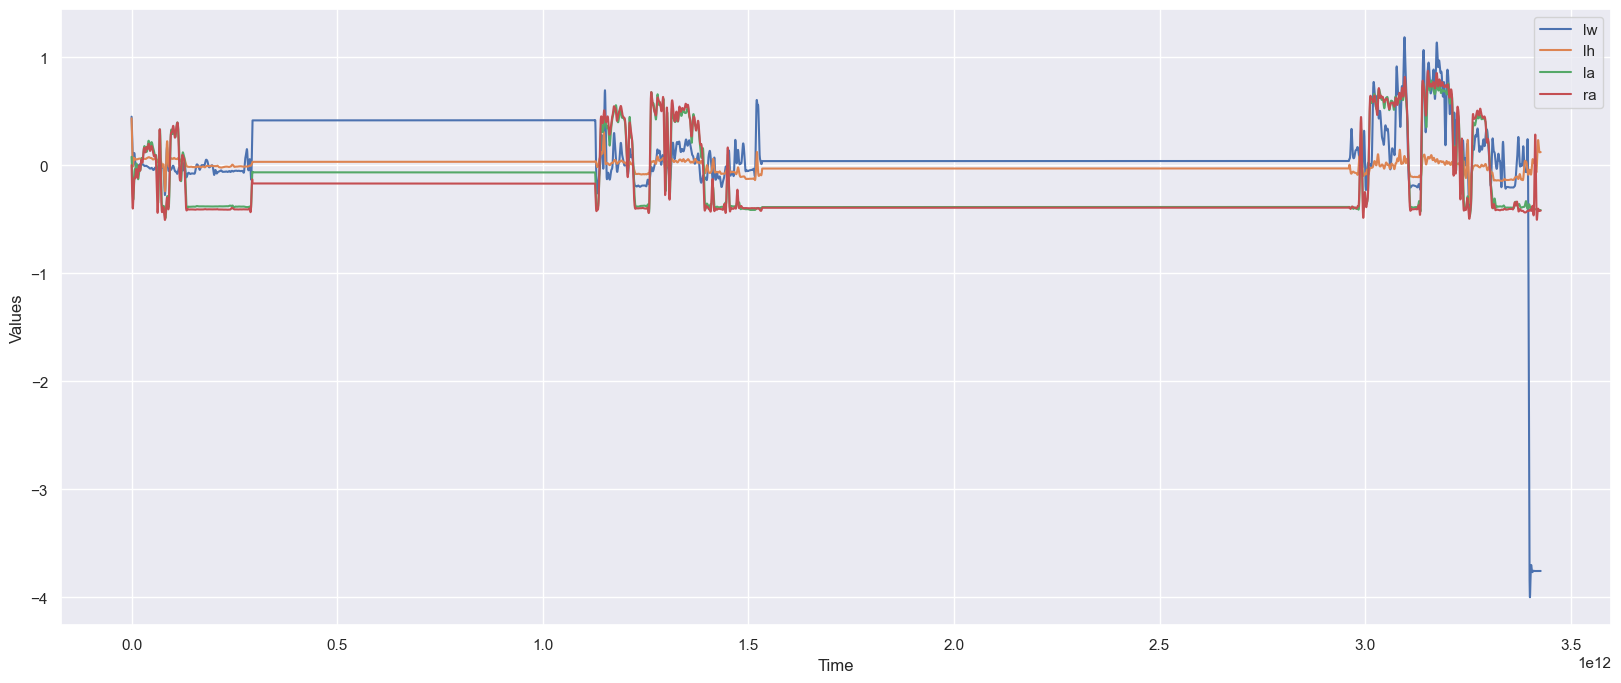

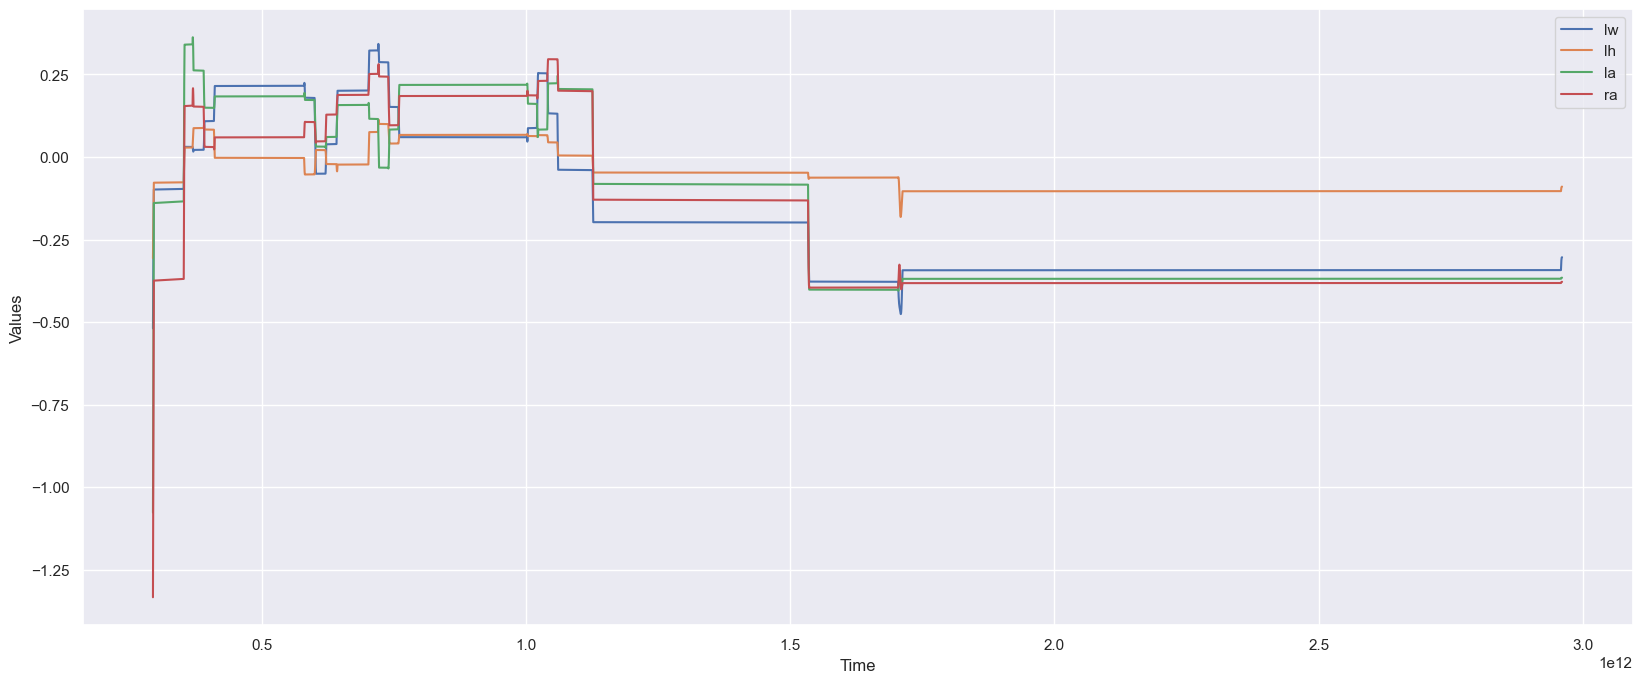

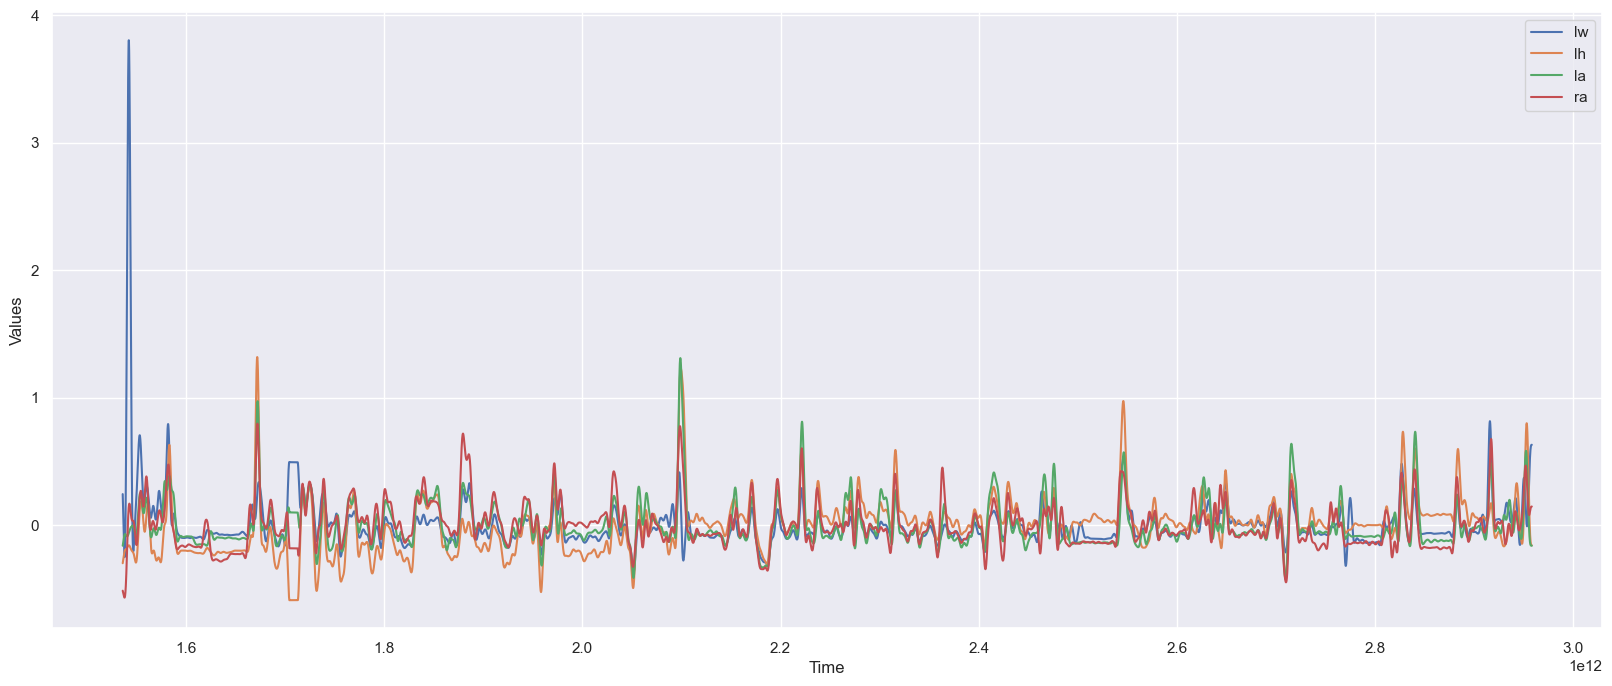

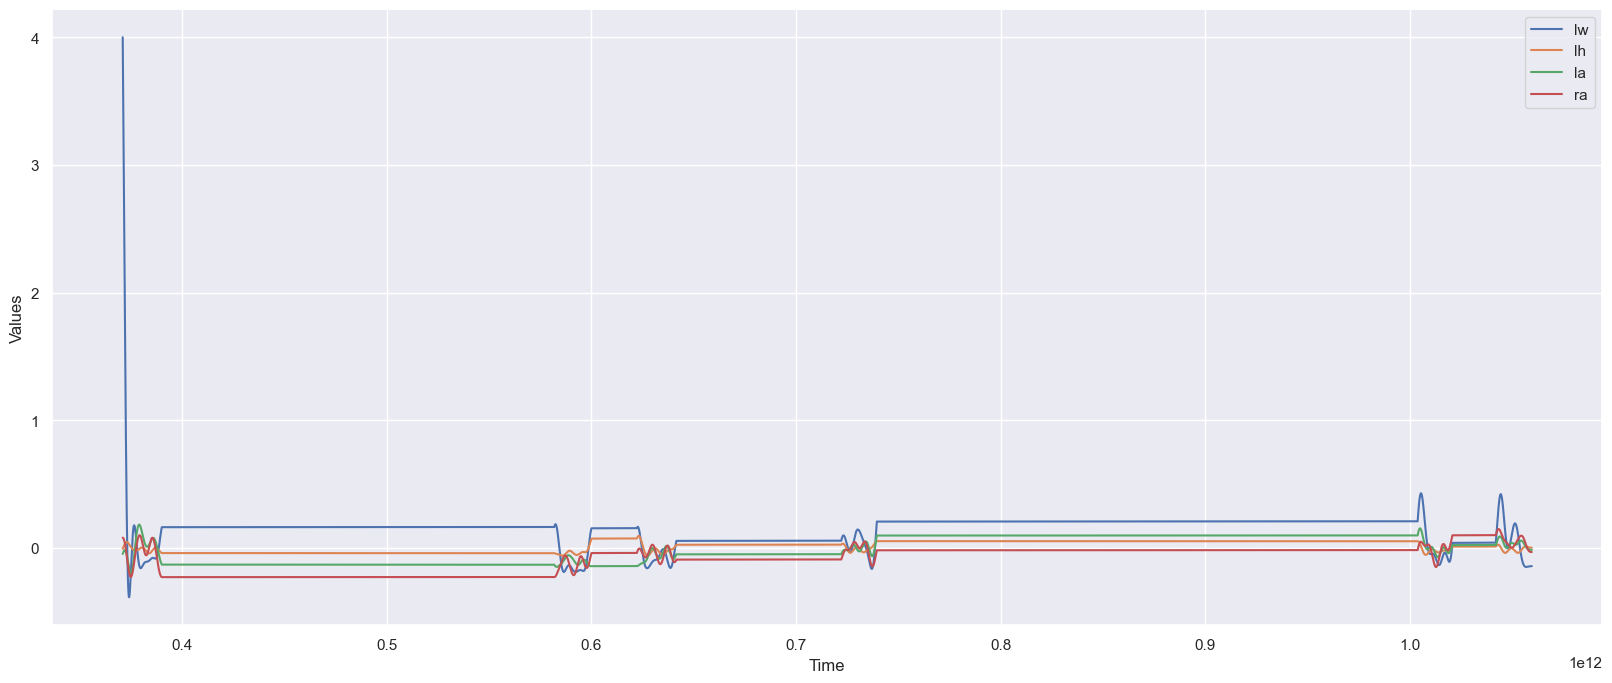

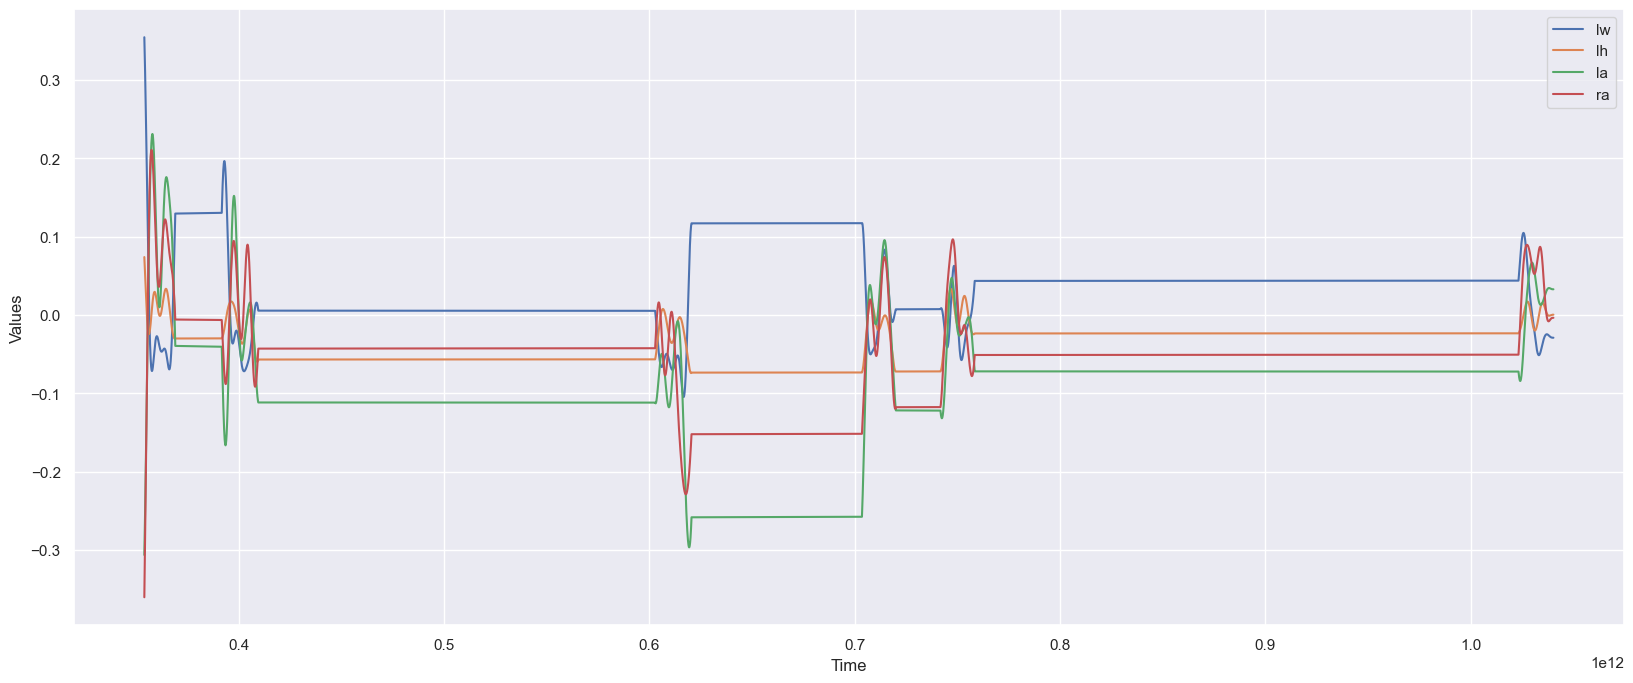

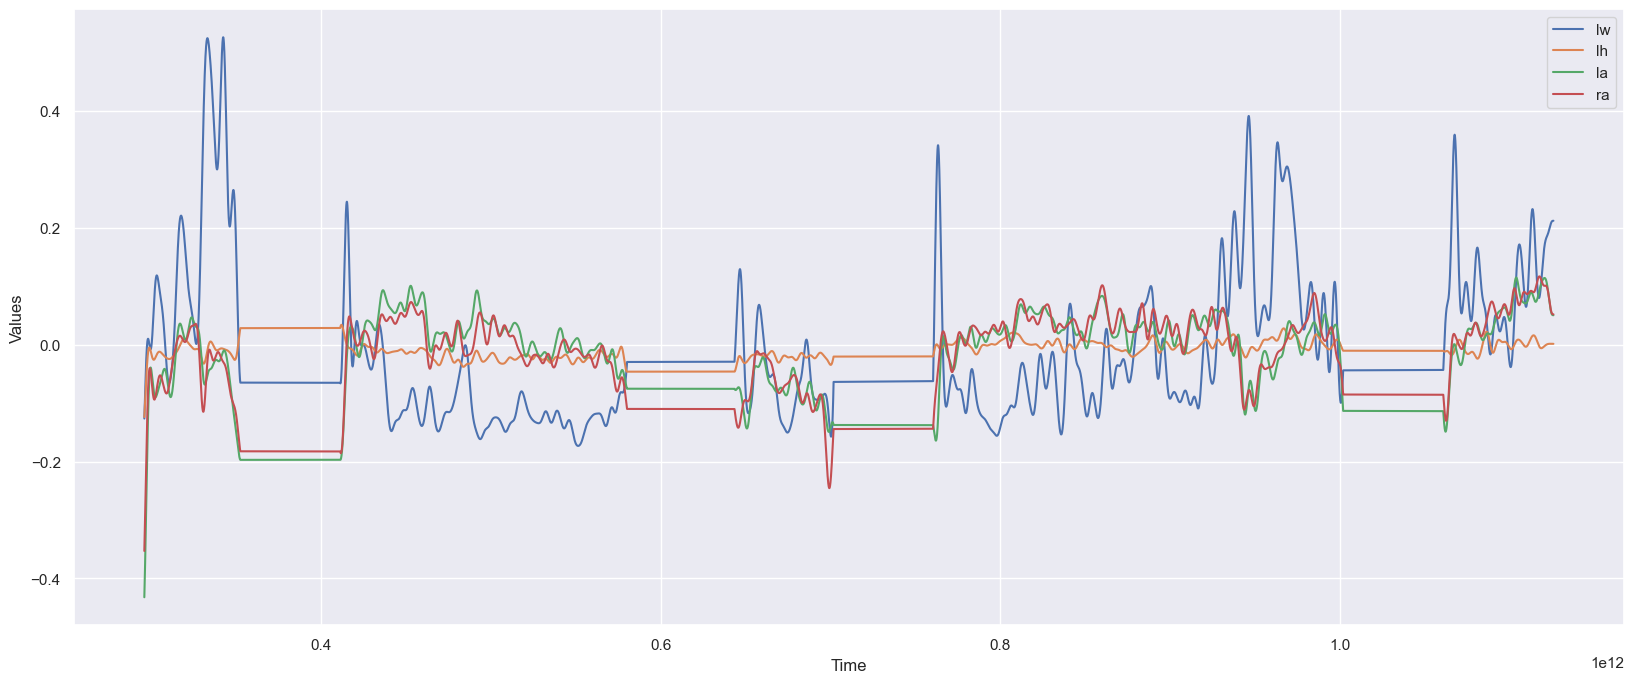

In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
#TODO: implement ARIMA for predicting furture trend or prophet

In [ ]:
#TODO: implement KNN 